In [33]:
import sys
import warnings
# If there are no warning options, ignore them
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [34]:
# Importing necessary libraries for data manipulation, visualization, and machine learning
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import timedelta
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
sns.set()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.random.set_random_seed(1234)
%matplotlib inline



In [35]:
# Importing yfinance library to fetch financial data
import yfinance as yf

# Fetching the data for Bitcoin from yfinance
df = yf.download("BTC-USD", start='2022-12-02', end='2023-12-02').reset_index()
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-02,16968.683594,17088.660156,16877.880859,17088.660156,17088.660156,19539705127
1,2022-12-03,17090.097656,17116.041016,16888.140625,16908.236328,16908.236328,16217776704
2,2022-12-04,16908.169922,17157.767578,16903.439453,17130.486328,17130.486328,16824520830
3,2022-12-05,17128.894531,17378.152344,16922.431641,16974.826172,16974.826172,22209086834
4,2022-12-06,16975.238281,17091.863281,16939.921875,17089.503906,17089.503906,19889922369
...,...,...,...,...,...,...,...
360,2023-11-27,37454.191406,37559.355469,36750.128906,37254.167969,37254.167969,19002925720
361,2023-11-28,37247.992188,38368.480469,36891.089844,37831.085938,37831.085938,21696137014
362,2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188,37858.492188,20728546658
363,2023-11-30,37861.117188,38141.753906,37531.140625,37712.746094,37712.746094,18115982627


In [36]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,2023-06-02 00:00:00,26685.130105,27112.941663,26332.510558,26744.943568,26744.943568,1.775852e+10
min,2022-12-02 00:00:00,16441.787109,16628.986328,16398.136719,16439.679688,16439.679688,5.331173e+09
25%,2023-03-03 00:00:00,23647.019531,24167.210938,23279.955078,23723.769531,23723.769531,1.194069e+10
50%,2023-06-02 00:00:00,27123.109375,27460.718750,26710.873047,27132.007812,27132.007812,1.565637e+10
75%,2023-09-01 00:00:00,29408.048828,29871.546875,29114.021484,29415.964844,29415.964844,2.169614e+10
max,2023-12-01 00:00:00,37879.980469,38954.109375,37629.359375,38688.750000,38688.750000,5.462223e+10
std,NaN,5102.630470,5206.416303,5021.446259,5117.044897,5117.044897,8.238023e+09


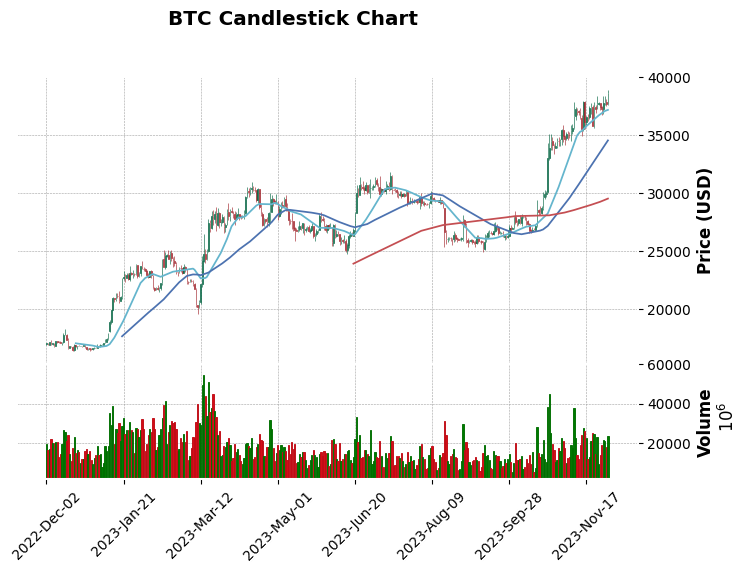

In [37]:
import mplfinance as mpf

# Make sure the 'Date' column is set as the index
df.set_index('Date', inplace=True, drop = False)
# Calculate the moving averages
ma20 = df['Adj Close'].rolling(window=20).mean()
ma50 = df['Adj Close'].rolling(window=50).mean()
ma200 = df['Adj Close'].rolling(window=200).mean()

# Create additional plots for the moving averages
aplots = [mpf.make_addplot(ma20, panel=0, color='c', secondary_y=False, ylabel='MA (20 days)'),
          mpf.make_addplot(ma50, panel=0, color='b', secondary_y=False, ylabel='MA (50 days)'),
          mpf.make_addplot(ma200, panel=0, color='r', secondary_y=False, ylabel='MA (200 days)')]

# Plot the candlestick chart with the additional plots
mpf.plot(df, type='candle', style='charles',
         title='BTC Candlestick Chart',
         ylabel='Price (USD)',
         ylabel_lower='Volume',
         volume=True,
         figratio=(15, 10),
         addplot=aplots)

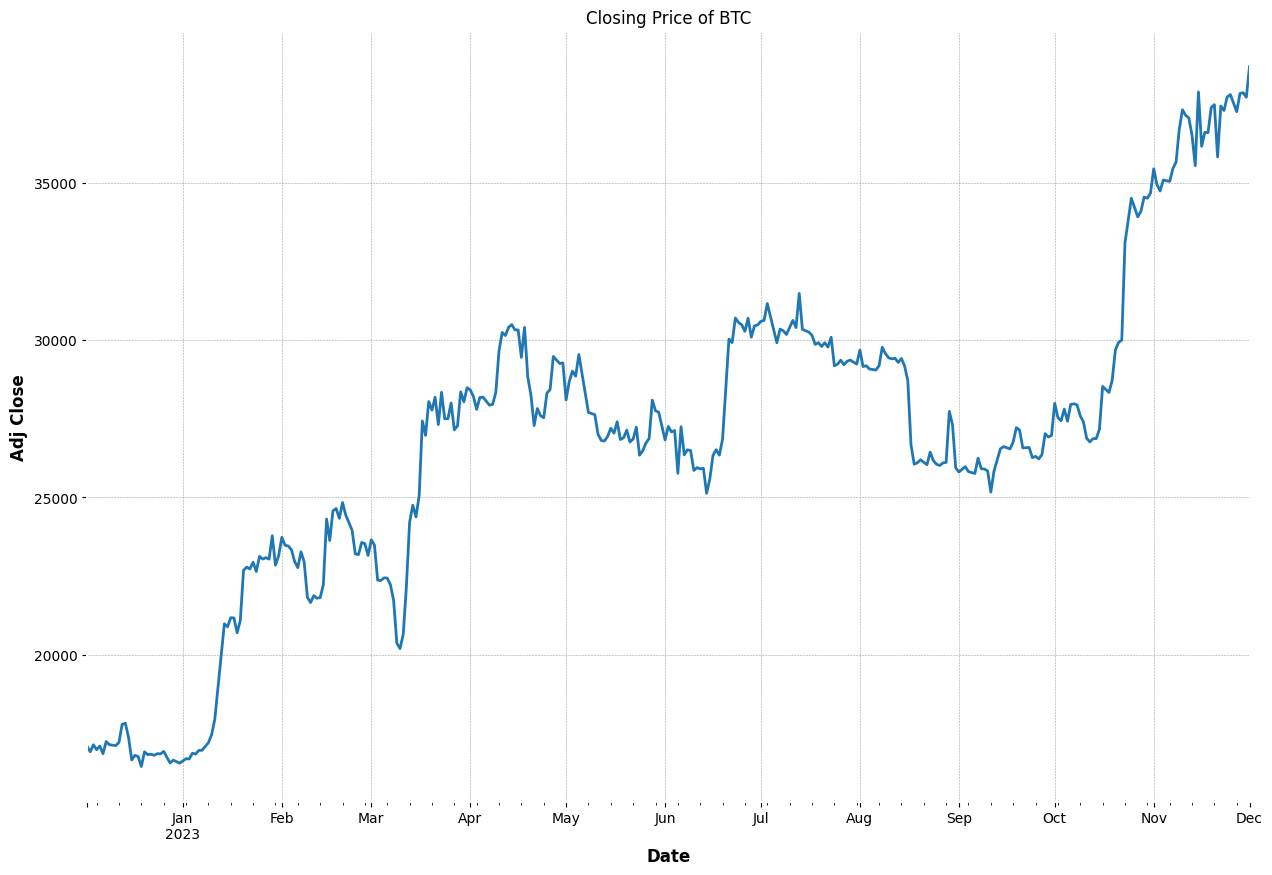

In [38]:
plt.figure(figsize=(15, 10))
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.title("Closing Price of BTC")
plt.show()

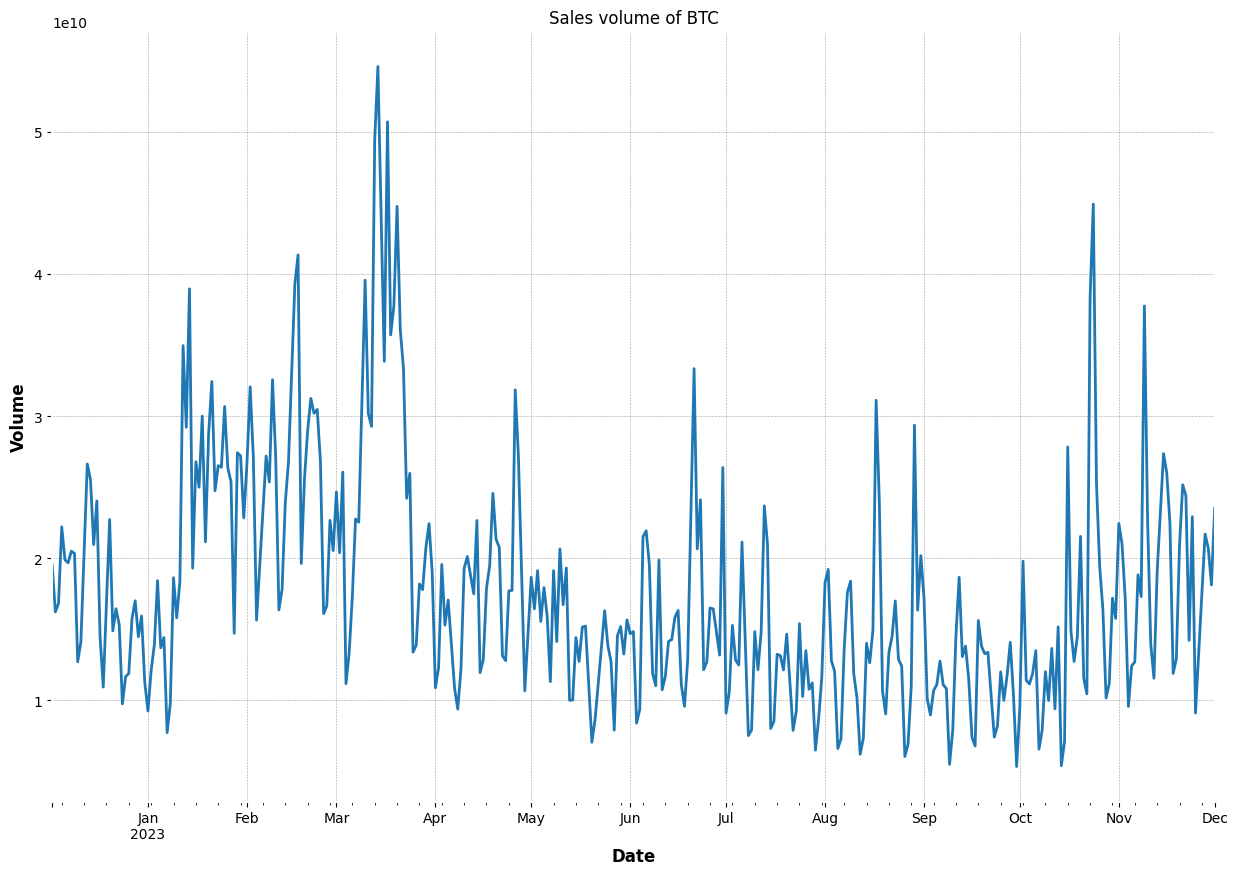

In [39]:
plt.figure(figsize=(15, 10))
df['Volume'].plot()
plt.ylabel('Volume')
plt.title("Sales volume of BTC")
plt.show()

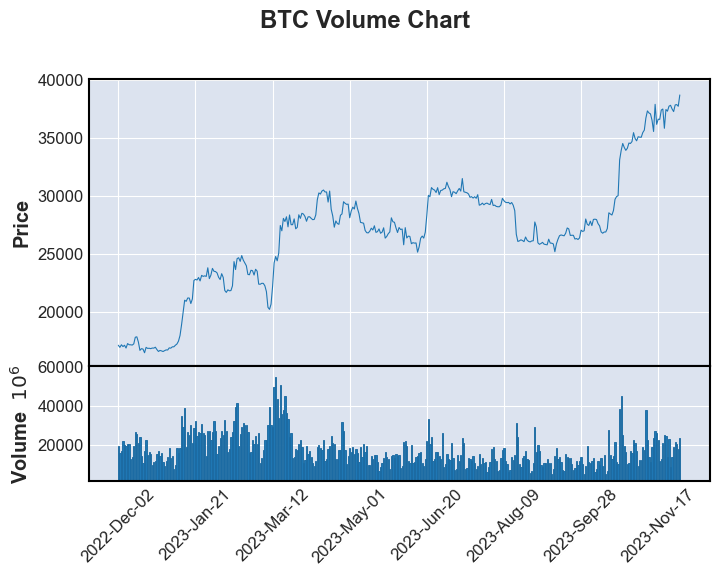

In [40]:
# Plot the volume chart
mpf.plot(df, type='line', volume=True, figratio=(15, 10), title='BTC Volume Chart')

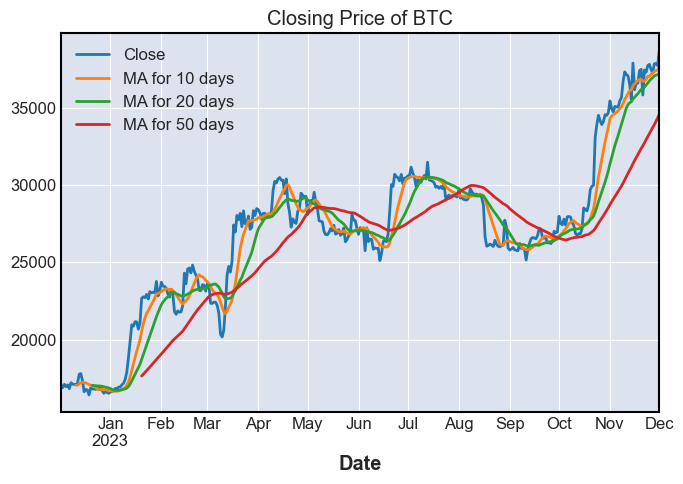

In [41]:
# Define a list of days for which moving averages will be calculated
ma_day = [10, 20, 50]
# Calculate the moving average for the specified number of days
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Close'].rolling(ma).mean()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(7)

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
ax.set_title('Closing Price of BTC')

fig.tight_layout()

Mean Squared Error: 8226048.261490369
Coefficient of determination (R^2): 0.758496380051889
Accuracy (%): 88.23919365497656


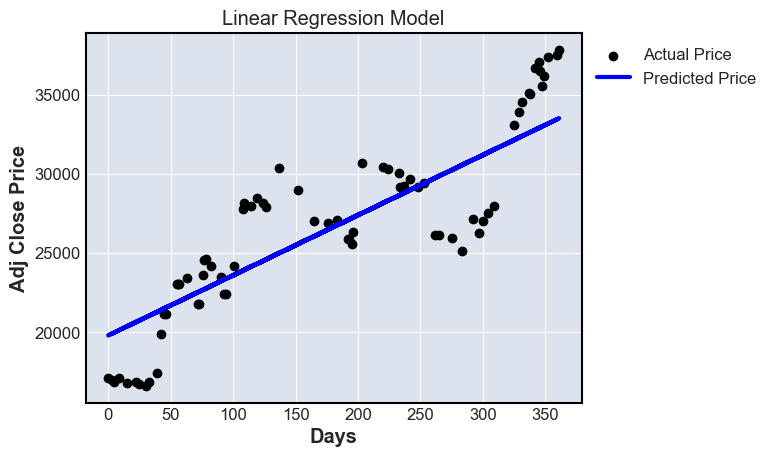

Predictions for the last 30 days: [27130.41094935 21055.01015823 20371.52756923 31535.07652291
 21966.3202769  26750.6983999  22687.77412084 24320.53808346
 25573.58949662 24586.33686807 32636.2429163  21282.8376879
 31345.22024819 21890.37776701 25004.02067246 31193.33522841
 19801.95874506 30244.0538548  32294.5016218  23637.05549446
 20143.70003956 26067.2158109  22535.88910107 29408.68624602
 29218.8299713  27206.35345924 28155.63483285 30889.56518885
 33053.92672069 33509.58178002 20751.24011868 23902.85427907
 21396.75145273 33167.84048552 27244.32471418 24130.68180873
 22194.14780657 20637.32635384 32788.12793608 32370.44413169
 28991.00244163 32902.04170091 20941.0963934  31079.42146358
 23940.82553401 28687.23240207 23219.37169007 21928.34902195
 19991.81501979 21510.66521757 28649.26114713 32940.01295586
 30547.82389435 29750.42754052 26484.89961529 32598.27166135
 23333.2854549  19915.8725099  33433.63927013 22725.74537579
 28801.14616691 32977.9842108  22763.71663073 21548.

In [48]:
# Convert 'Date' to a numeric value (e.g., number of days since the start of the dataset)
df['Day'] = (df['Date'] - df['Date'].min()).dt.days

# Prepare the data
X = df[['Day']]  # Features
y = df['Adj Close']  # Target variable

# Exclude the last 30 days for testing
# X_train = X[:-30]
# y_train = y[:-30]
# X_test = X[-30:]
# y_test = y[-30:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = calculate_accuracy(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Coefficient of determination (R^2): {r2}')
print(f'Accuracy (%): {accuracy}')

# Plot the results
plt.scatter(X_test, y_test, color='black', label='Actual Price')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Adj Close Price')
plt.title('Linear Regression Model')
plt.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)
plt.show()

# Output the predictions for the last 5 days
print("Predictions for the last 30 days:", y_pred)

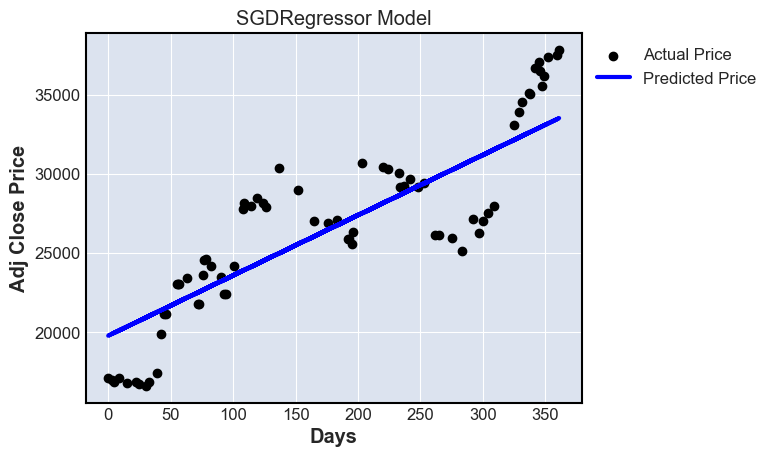

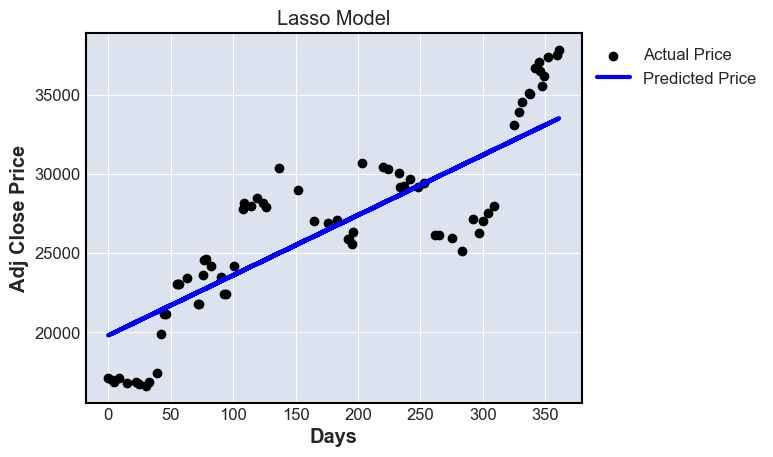

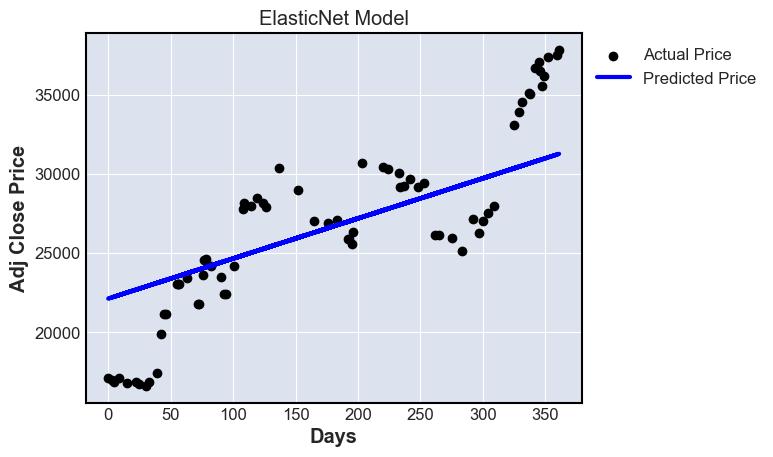

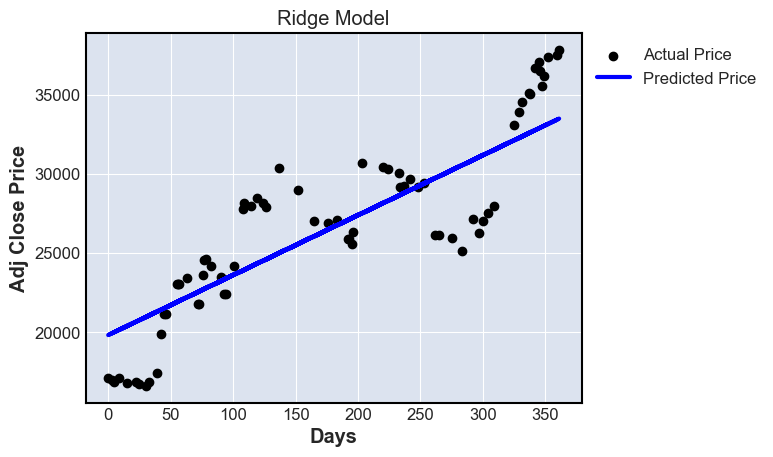

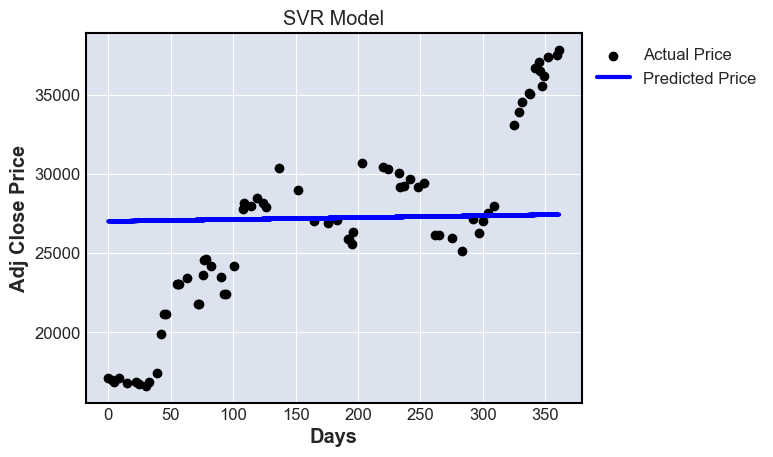

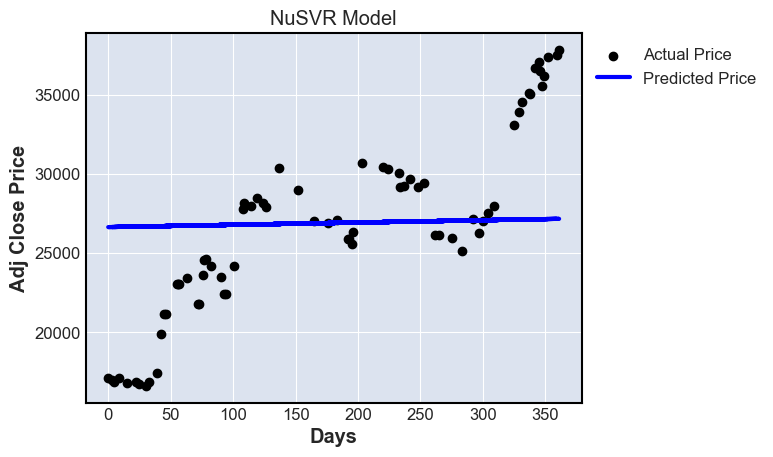

          model           mse  r_squared   accuracy
0  SGDRegressor  8.215579e+06   0.758804  88.256971
1         Lasso  8.227696e+06   0.758448  88.237274
2    ElasticNet  1.252520e+07   0.632280  84.577383
3         Ridge  8.248152e+06   0.757847  88.213547
4           SVR  3.300660e+07   0.030979  73.561804
5         NuSVR  3.243684e+07   0.047706  74.296467
Best model based on MSE: SGDRegressor(random_state=42)


In [43]:
# Set a random state seed to make the result reproducible
random_state = 42

# Define a list of models
models = [
    SGDRegressor(random_state=random_state),
    Lasso(random_state=random_state),
    ElasticNet(random_state=random_state),
    Ridge(random_state=random_state),
    SVR(kernel='linear'),
    NuSVR(kernel='linear')
]

# Modify the evaluate_model function to include accuracy calculation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    accuracy = calculate_accuracy(y_test, predictions)  # Calculate accuracy
    return mse, r2, accuracy, predictions

# Train and evaluate each model
results = []
for model in models:
    mse, r2, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)  # Include accuracy in the returned values
    results.append({
        'model': model.__class__.__name__,
        'mse': mse,
        'r_squared': r2,
        'accuracy': accuracy  # Add accuracy to the results
    })

    # Plot the results
    plt.scatter(X_test, y_test, color='black', label='Actual Price')
    plt.plot(X_test, predictions, color='blue', linewidth=3, label='Predicted Price')
    plt.xlabel('Days')
    plt.ylabel('Adj Close Price')
    plt.title(f'{model.__class__.__name__} Model')
    plt.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

# Find the best model based on MSE
best_model = models[results_df['mse'].idxmin()]

# Display the best model
print("Best model based on MSE:", best_model)

In [44]:
# Extract the 'Adj Close' column and convert it to numpy array
data = df['Adj Close'].values
data = data.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create the features and targets
X = []
y = []
for i in range(60, len(data)):
    X.append(data[i-60:i, 0])
    y.append(data[i, 0])

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape the features
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.029169
1,0.021060
2,0.031049
3,0.024053
4,0.029207


## Forecast

This example is using model three different models LSTM, LSTM Bidirectional, LSTM 2 path

The models will be used to predict 30 days ahead from the end of the dataset

Each model is simulated 5 times for 5 variances of forecasted patterns

In [46]:
# Set the number of simulations for the LSTM model
simulation_size = 5
# Set the number of layers in the LSTM model
num_layers = 1
# Set the size of each layer in the LSTM model
size_layer = 128
# Set the number of time steps to look back in the LSTM model
timestamp = 5
# Set the number of training iterations for the LSTM model
epoch = 300
# Set the dropout rate for the LSTM model, which is the proportion of neurons to ignore during training
dropout_rate = 0.8
# Set the size of the test dataset
test_size = 30
# Set the learning rate for the LSTM model, which determines how much the model changes in response to the estimated error each time the model weights are updated
learning_rate = 0.01
# Assign the training dataset to df_train
df_train = df_log
df.shape, df_train.shape

((365, 11), (365, 1))

Here's a brief explanation of each parameter in the LSTM models:
**simulation_size**: This is the number of times the LSTM model will be trained and tested. Each simulation might produce slightly different results due to the randomness in the training process.
**num_layers**: This is the number of layers in the LSTM model. Each layer contains a certain number of LSTM cells or neurons.
**size_layer**: This is the number of LSTM cells (or neurons) in each layer.
**timestamp**: This is the number of time steps to look back in the LSTM model. It's the window of previous time step information that the model will have access to when predicting the next time step.
**epoch**: This is the number of training iterations. In each epoch, the LSTM model learns the weights for its neurons based on the entire training dataset.
**dropout_rate**: This is the proportion of neurons which will be ignored during training. It's a regularization technique to prevent overfitting.
**test_size**: This is the size of the test dataset. The model will be trained on the rest of the data.
**learning_rate**: This determines how much the model changes in response to the estimated error each time the model weights are updated. A smaller learning rate might lead to more accurate training results, but the process will be slower.

In [47]:
# Define the LSTM model class
class Model_LSTM:
    # Initialize the model with given parameters
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        # Define a function to create an LSTM cell
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        # Create a multi-layer RNN with LSTM cells
        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        # Define placeholders for the input and output data
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        # Apply dropout to the RNN cells to prevent overfitting
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        # Define a placeholder for the hidden layer
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        # Define the RNN structure using dynamic_rnn function
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        # Define the output layer using a dense layer
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        # Define the cost function (mean squared error)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        # Define the optimizer (Adam optimizer)
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
# Define a function to smooth the signal using exponential smoothing
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [51]:
# Define the Bidirectional LSTM model
class Model_LSTM_Bidirectional:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        # Define a LSTM cell
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        # Create backward and forward LSTM cells
        backward_rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        # Define placeholders for input and output
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        # Apply dropout to the LSTM cells
        drop_backward = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        # Define placeholders for the hidden layers
        self.backward_hidden_layer = tf.compat.v1.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.compat.v1.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        # Define the bidirectional dynamic RNN
        self.outputs, self.last_state = tf.compat.v1.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        # Concatenate the outputs
        self.outputs = tf.concat(self.outputs, 2)
        # Define the output layer
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        # Define the cost function
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        # Define the optimizer
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [52]:
# Define the LSTM model class with two separate paths
class Model_LSTM_2path:
    # Initialize the model with given parameters
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        # Define a function to create an LSTM cell
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        # Create forward LSTM cells with a variable scope to avoid conflicts
        with tf.compat.v1.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.compat.v1.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.compat.v1.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.compat.v1.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )
        # Create backward LSTM cells with a separate variable scope
        with tf.compat.v1.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.compat.v1.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.compat.v1.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.compat.v1.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )
        # Subtract the outputs of the forward path from the backward path
        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [53]:
def forecast_LSTM():
    # Reset the default graph. This is a way to clear the loaded graph in memory.
    tf.compat.v1.reset_default_graph()

    # Initialize the LSTM model with the given parameters.
    modelnn = Model_LSTM(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )

    # Start a new TensorFlow session.
    sess = tf.compat.v1.InteractiveSession()

    # Initialize all the variables in the graph.
    sess.run(tf.compat.v1.global_variables_initializer())

    # Convert the dates in the data to a list.
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    # Initialize a progress bar for the training loop.
    pbar = tqdm(range(epoch), desc = 'train loop')

    # Training loop for the LSTM model.
    for i in pbar:
        # Initialize the hidden state.
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []

        # Loop over the training data in batches.
        for k in range(0, df_train.shape[0] - 1, timestamp):
            # Get the current batch of data.
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values

            # Run the model on the current batch of data.
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )

            # Update the hidden state.
            init_value = last_state

            # Keep track of the loss and accuracy.
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

        # Update the progress bar with the current loss and accuracy.
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    # Set the number of future predictions.
    future_day = test_size

    # Initialize the array for the predictions.
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    # Generate predictions on the training data.
    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    # Generate predictions on the remaining data.
    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    # Generate predictions on the future data.
    init_value = last_state
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    # Inverse the transformation to get the original scale.
    output_predict = minmax.inverse_transform(output_predict)

    # Apply a function to smooth the predictions.
    deep_future = anchor(output_predict[:, 0], 0.4)

    # Return the predictions.
    return deep_future

In [54]:
def forecast_LSTM_Bi():
    # Reset the default graph to avoid conflicts with previous runs
    tf.compat.v1.reset_default_graph()

    # Initialize the bidirectional LSTM model
    modelnn = Model_LSTM_Bidirectional(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )

    # Start a new TensorFlow session
    sess = tf.compat.v1.InteractiveSession()

    # Initialize all the variables in the graph
    sess.run(tf.compat.v1.global_variables_initializer())

    # Convert the dates to a list
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    # Training loop
    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        # Initialize the forward and backward hidden states
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        # Loop over the training data in batches
        for k in range(0, df_train.shape[0] - 1, timestamp):
            # Get the current batch
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            # Run the model on the current batch
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )
            # Update the hidden states
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            # Keep track of the loss and accuracy
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        # Update the progress bar
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    # Forecasting
    future_day = test_size

    # Initialize the output array
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    # Loop over the training data in batches
    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        # Run the model on the current batch
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        # Update the hidden states
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        # Store the model's predictions
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    # If there are any remaining data points, process them
    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    # Initialize the hidden states for the future predictions
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]

    # Predict the future
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        # Update the hidden states
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        # Store the model's predictions
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    # Reverse the scaling of the data
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future

In [55]:
# Function to forecast using LSTM
def forecast_LSTM_2path():
    # Reset the default graph to avoid conflicts with any previously defined models
    tf.compat.v1.reset_default_graph()

    # Initialize the LSTM model
    modelnn = Model_LSTM_2path(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )

    # Start a new TensorFlow session
    sess = tf.compat.v1.InteractiveSession()

    # Initialize all the variables in the session
    sess.run(tf.compat.v1.global_variables_initializer())

    # Convert the dates to a list
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    # Training loop
    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        # Initialize the forward and backward hidden states
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []

        # Loop over the training data in batches
        for k in range(0, df_train.shape[0] - 1, timestamp):
            # Get the current batch of data
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values

            # Run the model on the current batch of data
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )

            # Update the hidden states
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward

            # Keep track of the loss and accuracy
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

        # Update the progress bar
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    # Initialize the prediction array
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    # Loop over the training data in batches to make predictions
    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        # Get the current batch of data
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )

        # Run the model on the current batch of data
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )

        # Update the hidden states
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward

        # Store the predictions
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    # If there are any remaining data points, make predictions on them
    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    # Make predictions for the future
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    # Inverse the transformation to get the original scale
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future

Description for each model
**3.1 Unidirectional LSTM**
First, we define a Long Short-Term Memory (LSTM) model for sequential data processing. The Model_LSTM class is initialized with various parameters, including learning rate, number of layers, input size, layer size, output size, and forget bias.
Inside the class, a function named lstm_cell is defined to create an LSTM cell with a specified size. Subsequently, a multi-layer Recurrent Neural Network (RNN) is constructed using LSTM cells, with the number of layers determined by the num_layers parameter. This RNN is encapsulated in a DropoutWrapper to mitigate overfitting, applying dropout to the RNN cells with a dropout rate specified by the forget_bias parameter.
Placeholders are declared for input (self.X) and output (self.Y) data, representing a 3D tensor for input sequences and a 2D tensor for target outputs, respectively. Additionally, a placeholder for the hidden layer (self.hidden_layer) is defined, representing the initial state of the hidden layers.
The dynamic RNN is established using tf.nn.dynamic_rnn, taking into account the dropout-wrapped RNN cells (drop), input data (self.X), and initial hidden layer state (self.hidden_layer). This RNN processes the input sequence and produces both the output sequence (self.outputs) and the final state of the hidden layers (self.last_state).
A dense output layer is applied to the last output of the RNN (self.outputs[-1]) using tf.layers.dense, resulting in the model's predictions (self.logits). The cost function, calculated as the mean squared error between predictions and target outputs, is defined using tf.reduce_mean(tf.square(self.Y - self.logits)).
The Adam optimizer is employed to minimize the cost during training, and the optimization operation is stored in self.optimizer. The model is now capable of processing sequential data, and it can be trained and evaluated for tasks such as time series prediction or sequence-to-sequence learning.
Additionally, the script includes auxiliary functions. calculate_accuracy computes the accuracy of model predictions against actual values. anchor implements exponential smoothing on a signal using a weighted average, which can be useful for smoothing noisy data. These functions contribute to the overall utility of the script, enabling a comprehensive approach to handling and analyzing sequential data.
In the forecasting phase, the number of future predictions (future_day) is set, and an array (output_predict) is initialized to store the predictions. The initial hidden state (init_value) is set to zeros, and predictions are generated for the training data in batches. If there are remaining data points, predictions are generated for them as well. Subsequently, predictions are made for the future data, and the hidden state is updated at each step.
The resulting predictions are transformed back to the original scale using inverse scaling. To enhance the forecast, exponential smoothing is applied using the anchor function. Finally, the script returns the smoothed predictions (deep_future). In essence, the script defines, trains, and utilizes an LSTM model for time series forecasting, leveraging sequential information in the data to make accurate predictions.

**3.2 Bidirectional LSTM**
Firstly, the model is encapsulated in the Model_LSTM_Bidirectional class, which is initialized with various parameters like learning rate, number of layers, input size, layer size, output size, and forget bias. The class contains a method __init__ that sets up the architecture of the Bi-LSTM model using TensorFlow. It includes placeholders for input (self.X) and output (self.Y) data, representing the input sequence and target output, respectively.
Two sets of LSTM cells, one for the forward pass and another for the backward pass, are created using the lstm_cell function. These cells are then encapsulated in DropoutWrapper to apply dropout regularization, and placeholders (self.forward_hidden_layer and self.backward_hidden_layer) are defined for the initial hidden states of the forward and backward cells.
The bidirectional dynamic RNN is constructed using tf.nn.bidirectional_dynamic_rnn, taking into account the forward and backward cells, the input sequence (self.X), and the initial hidden states. The outputs from both directions are concatenated, forming the bidirectional output sequence (self.outputs).
A dense layer is applied to the last element of the output sequence to obtain the final predictions (self.logits). The mean squared error is used as the cost function (self.cost), and the Adam optimizer is employed to minimize this cost during training (self.optimizer).
The forecast_LSTM_Bi function is then defined to train and predict future values using the Bi-LSTM model. It starts by resetting the default TensorFlow graph and initializing the Bi-LSTM model with specified parameters. A TensorFlow session is created, and all variables are initialized.
The training loop begins, iterating over epochs and processing the training data in batches. The forward and backward hidden states are updated at each step, and the loss and accuracy metrics are tracked.
After training, the script proceeds to forecasting. The future data points are predicted iteratively, and the hidden states are updated accordingly. The predictions are then transformed back to the original scale, and an exponential smoothing function (anchor) is applied to the forecasted values.
The script concludes with returning the forecasted values (deep_future) for further analysis or visualization.

**3.3 Two-path LSTM**
This model is designed with two separate paths: forward and backward. The purpose of this dual-path architecture is to capture bidirectional temporal dependencies in the input time series data.

The class initialization defines the model's architecture. Two sets of LSTM cells are created within separate variable scopes, 'forward' and 'backward'. These cells constitute the forward and backward paths, each consisting of multiple layers specified by the num_layers parameter. Dropout is applied to these cells to prevent overfitting. Placeholders (self.X_forward and self.X_backward) are declared for input sequences along each path, and placeholders (self.hidden_layer_forward and self.hidden_layer_backward) are set for the initial hidden states.

The forward and backward paths are executed independently using the dynamic_rnn function, taking into account the corresponding input sequences and initial hidden states. Importantly, the output sequences from the forward path are subtracted from those of the backward path (self.outputs_backward - self.outputs_forward). This subtraction is designed to capture the bidirectional nature of temporal dependencies in the data.

The rest of the class initialization defines the output layer, cost function, and optimizer for training the model. The final output (self.logits) is obtained by applying a dense layer to the subtracted output sequences.

The training loop in the forecast_LSTM_2path function follows a similar structure to the previously explained LSTM model. The model is initialized, and a new TensorFlow session is started. The training loop iterates through epochs, and within each epoch, it processes the training data in batches. For each batch, the model is run on both forward and backward paths, updating the hidden states and calculating loss and accuracy.

The forecasting phase is then executed. The script initializes the prediction array and iterates through the training data to make predictions. If there are remaining data points, predictions are generated for them as well. Finally, predictions are made for future data points, and the hidden states are updated at each step.

The resulting predictions are transformed back to the original scale using inverse scaling. Additionally, the anchor function is applied for exponential smoothing. The script concludes by returning the smoothed predictions (deep_future).


In [56]:
# Run the models
model_names = ['LSTM', 'LSTM_Bi', 'LSTM_2path']
model_functions = [forecast_LSTM, forecast_LSTM_Bi, forecast_LSTM_2path]

results = []
for i in range(simulation_size):
    for model_name, model_func in zip(model_names, model_functions):
        print(f'simulation {i+1}, model: {model_name}')
        results.append(model_func())

simulation 1, model: LSTM


train loop: 100%|██████████| 300/300 [02:05<00:00,  2.39it/s, acc=97.9, cost=0.00112] 


simulation 1, model: LSTM_Bi


train loop: 100%|██████████| 300/300 [02:49<00:00,  1.77it/s, acc=97.6, cost=0.00157] 


simulation 1, model: LSTM_2path


train loop: 100%|██████████| 300/300 [02:42<00:00,  1.84it/s, acc=97.8, cost=0.00122] 


simulation 2, model: LSTM


train loop: 100%|██████████| 300/300 [01:31<00:00,  3.29it/s, acc=97.8, cost=0.00118] 


simulation 2, model: LSTM_Bi


train loop: 100%|██████████| 300/300 [02:40<00:00,  1.87it/s, acc=98, cost=0.00106]   


simulation 2, model: LSTM_2path


train loop: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, acc=97.8, cost=0.0012]  


simulation 3, model: LSTM


train loop: 100%|██████████| 300/300 [01:39<00:00,  3.01it/s, acc=97.7, cost=0.00124]


simulation 3, model: LSTM_Bi


train loop: 100%|██████████| 300/300 [02:13<00:00,  2.25it/s, acc=97.8, cost=0.00113] 


simulation 3, model: LSTM_2path


train loop: 100%|██████████| 300/300 [02:36<00:00,  1.92it/s, acc=97.6, cost=0.00139] 


simulation 4, model: LSTM


train loop: 100%|██████████| 300/300 [01:51<00:00,  2.69it/s, acc=97.8, cost=0.00122]


simulation 4, model: LSTM_Bi


train loop: 100%|██████████| 300/300 [02:07<00:00,  2.35it/s, acc=98, cost=0.000993]  


simulation 4, model: LSTM_2path


train loop: 100%|██████████| 300/300 [02:06<00:00,  2.37it/s, acc=97.9, cost=0.00112] 


simulation 5, model: LSTM


train loop: 100%|██████████| 300/300 [01:44<00:00,  2.88it/s, acc=98, cost=0.00103]  


simulation 5, model: LSTM_Bi


train loop: 100%|██████████| 300/300 [02:04<00:00,  2.41it/s, acc=98, cost=0.001]     


simulation 5, model: LSTM_2path


train loop: 100%|██████████| 300/300 [02:04<00:00,  2.41it/s, acc=98.2, cost=0.000847]


Model LSTM, Simulation 1, Accuracy: 94.05%
Model LSTM_Bi, Simulation 1, Accuracy: 92.51%
Model LSTM_2path, Simulation 1, Accuracy: 93.64%
Model LSTM, Simulation 2, Accuracy: 91.82%
Model LSTM_Bi, Simulation 2, Accuracy: 94.16%
Model LSTM_2path, Simulation 2, Accuracy: 94.13%
Model LSTM, Simulation 3, Accuracy: 95.36%
Model LSTM_Bi, Simulation 3, Accuracy: 94.38%
Model LSTM_2path, Simulation 3, Accuracy: 92.39%
Model LSTM, Simulation 4, Accuracy: 95.42%
Model LSTM_Bi, Simulation 4, Accuracy: 94.10%
Model LSTM_2path, Simulation 4, Accuracy: 94.17%
Model LSTM, Simulation 5, Accuracy: 93.22%
Model LSTM_Bi, Simulation 5, Accuracy: 94.59%
Model LSTM_2path, Simulation 5, Accuracy: 92.40%
Model LSTM average accuracy: 93.97%
Model LSTM_Bi average accuracy: 93.95%
Model LSTM_2path average accuracy: 93.35%


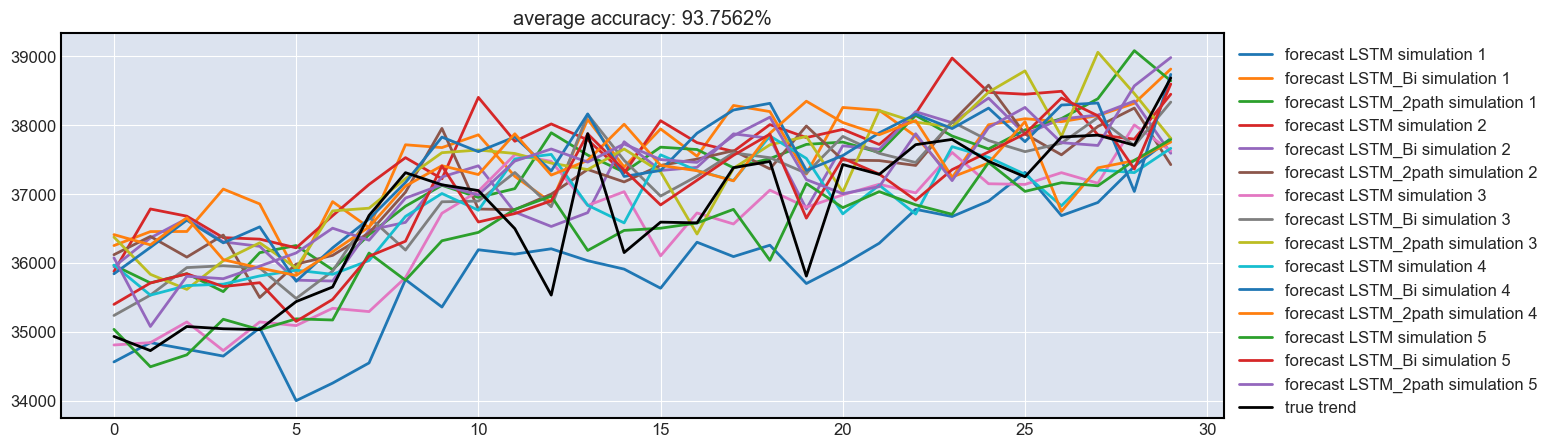

In [57]:
model_names = ['LSTM', 'LSTM_Bi', 'LSTM_2path']
# Calculating the accuracy for each model
accuracies = []
for i in range(simulation_size):
    model_accuracies = []
    for j in range(3):  # Since there are 3 models
        model_result = results[i * 3 + j]
        model_result = model_result[-test_size:]
        accuracy = calculate_accuracy(df['Close'].iloc[-test_size:].values, model_result)
        model_accuracies.append(accuracy)
        print(f'Model {model_names[j]}, Simulation {i+1}, Accuracy: {accuracy:.2f}%')
    accuracies.append(model_accuracies)

# Calculate the average accuracy per model
average_accuracies = [np.mean([acc[i] for acc in accuracies]) for i in range(3)]
for i, avg_acc in enumerate(average_accuracies):
    print(f'Model {model_names[i]} average accuracy: {avg_acc:.2f}%')

plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r[-2*test_size:-test_size], label=f'forecast {model_names[no % 3]} simulation {no // 3 + 1}')
plt.plot(df['Close'].iloc[-test_size:].values, label='true trend', c='black')
plt.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)
plt.title(f'average accuracy: {np.mean(average_accuracies):.4f}%')
plt.show()

In [58]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-test_size:]

['2023-12-02',
 '2023-12-03',
 '2023-12-04',
 '2023-12-05',
 '2023-12-06',
 '2023-12-07',
 '2023-12-08',
 '2023-12-09',
 '2023-12-10',
 '2023-12-11',
 '2023-12-12',
 '2023-12-13',
 '2023-12-14',
 '2023-12-15',
 '2023-12-16',
 '2023-12-17',
 '2023-12-18',
 '2023-12-19',
 '2023-12-20',
 '2023-12-21',
 '2023-12-22',
 '2023-12-23',
 '2023-12-24',
 '2023-12-25',
 '2023-12-26',
 '2023-12-27',
 '2023-12-28',
 '2023-12-29',
 '2023-12-30',
 '2023-12-31']

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [59]:
# Define the names of the models
model_names = ['LSTM', 'LSTM_Bi', 'LSTM_2path']

# Initialize an empty list for each model in a dictionary
accepted_results = {name: [] for name in model_names}

# Loop over the number of simulations
for i in range(simulation_size):
    # Loop over the number of models
    for j in range(3):  # Since there are 3 models
        # Get the result corresponding to the current simulation and model
        r = results[i * 3 + j]
        # Check if all values in the last 'test_size' elements of 'r' are within a certain range
        # The range is defined as being greater than the minimum and less than twice the maximum of 'df['Close']'
        if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
        (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
            # If the condition is met, append the result to the corresponding model in the dictionary
            accepted_results[model_names[j]].append(r)

# Loop over the models and their corresponding results in the dictionary
for name, results in accepted_results.items():
    # Print the model name and the number of accepted results
    print(f'Model {name}, accepted results: {len(results)}')

Model LSTM, accepted results: 5
Model LSTM_Bi, accepted results: 5
Model LSTM_2path, accepted results: 5


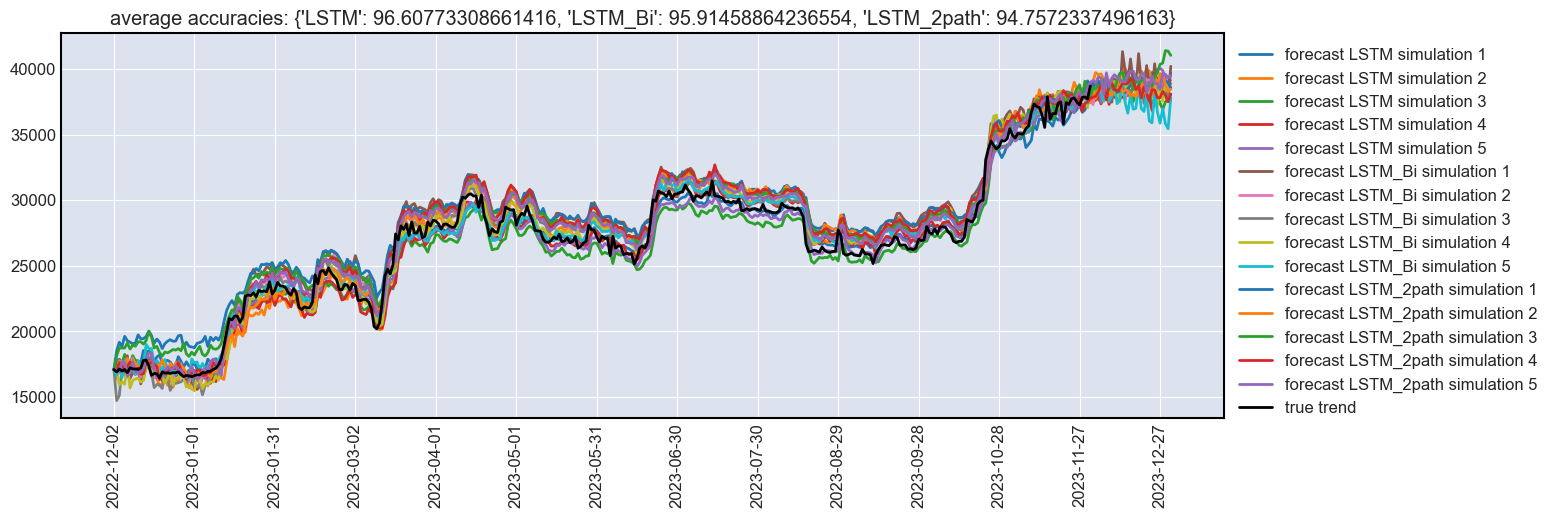

In [60]:
# Predict data in the future (need checking when complete)
accuracies = {name: [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in results]
              for name, results in accepted_results.items()}

plt.figure(figsize = (15, 5))

# Plot accepted results for each model
for name, results in accepted_results.items():
    for no, r in enumerate(results):
        plt.plot(r, label=f'forecast {name} simulation {no + 1}')

plt.plot(df['Close'].values, label='true trend', c='black')

# Calculate and display average accuracy for each model
average_accuracies = {name: np.mean(acc) for name, acc in accuracies.items()}
plt.title(f'average accuracies: {average_accuracies}')

x_range_future = np.arange(len(results[0]))

# Rotate x-axis labels
plt.xticks(x_range_future[::test_size], date_ori[::test_size], rotation='vertical')

plt.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True)

plt.show()

# Hyperparameter Tuning
In this part we have tried to tune the hyperparameters using the keras-tuner library. However, the results are significantly worse than the original parameters, therefore we chose to keep the original hyperparameters of the LSTM models. The result of the original run of the tuner can be found in the report.

However, we also tried to predict the movement of the price for the next day in percentage change instead of predicting the original price. After running the models, we found out that the LSTM models have great difficulties in predicting the movement of the price for the next day.
This code will demonstrate the variability between the real movement and the prediction

**Note:** The below part of this code must be copied and run in a new notebook. Since there are problems with the tensorflow library that makes this code conflict with the code above.

In [4]:
import sys
import warnings
# If there are no warning options, ignore them
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [5]:
dftuner = yf.download("BTC-USD", start='2022-12-02', end='2023-12-02')

tempDf = dftuner.reset_index()
tempDf.set_index("Date", inplace=True, drop=False)
dftuner['Day'] = (tempDf['Date'] - tempDf['Date'].min()).dt.days

dftuner

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Day
Date,,,,,,,
2022-12-02,16968.683594,17088.660156,16877.880859,17088.660156,17088.660156,19539705127,0
2022-12-03,17090.097656,17116.041016,16888.140625,16908.236328,16908.236328,16217776704,1
2022-12-04,16908.169922,17157.767578,16903.439453,17130.486328,17130.486328,16824520830,2
2022-12-05,17128.894531,17378.152344,16922.431641,16974.826172,16974.826172,22209086834,3
2022-12-06,16975.238281,17091.863281,16939.921875,17089.503906,17089.503906,19889922369,4
...,...,...,...,...,...,...,...
2023-11-27,37454.191406,37559.355469,36750.128906,37254.167969,37254.167969,19002925720,360
2023-11-28,37247.992188,38368.480469,36891.089844,37831.085938,37831.085938,21696137014,361
2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188,37858.492188,20728546658,362


<Axes: title={'center': 'BTC return'}, xlabel='Date'>

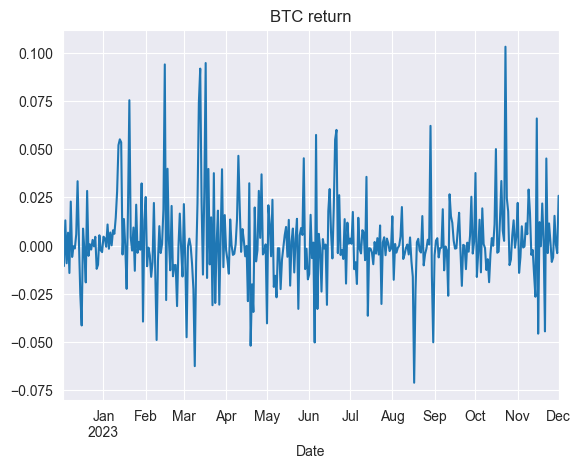

In [6]:
# omit this block of code to predict the actual price of bitcoin instead of price movement
# create price movement graph
dftuner['Close']=dftuner['Close'].pct_change()
dftuner['Close'].plot(title="BTC return")

In [7]:
sc = StandardScaler()
# Function to preprocess time series data for machine learning
def preproc( data, lag, ratio):
     # Extract and normalize the 'Close' column of the input data
    data=data.dropna().iloc[:, 3:4]
    Dates=data.index.unique()
    data.iloc[:, 0] = sc.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    # Create lag features for the time series data
    for s in range(1, lag):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(['Close'], axis=1)
    y_data = data.dropna()[['Close']]

      # Split the dataset into training and testing sets based on the specified ratio
    index=int(round(len(X_data)*ratio))
    X_data_train=X_data.iloc[:index,:]
    X_data_test =X_data.iloc[index+1:,:]
    y_data_train=y_data.iloc[:index,:]
    y_data_test =y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;

In [8]:
a,b,c,d,e=preproc(dftuner, 25, 0.90)
a = a.values
b= b.values
c = c.values
d = d.values

In [9]:
# Reshape training data (a) for LSTM input
X_train_t = a.reshape(a.shape[0], 1, 24)
# Reshape testing data (b) for LSTM input
X_test_t = b.reshape(b.shape[0], 1, 24)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [10]:
# Clear the Keras session to release resources and avoid conflicts
K.clear_session()
# Define early stopping to prevent overfitting and save training time
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
# Create a sequential model using Keras
model = Sequential()
# Add the first LSTM layer with 12 units, input shape (1, 24), and return sequences for the next layer
model.add(LSTM(12, input_shape=(1, 24), return_sequences=True))

# Add a second LSTM layer with 6 units
model.add(LSTM(6))
# Add a dense layer with 6 units
model.add(Dense(6))
# Add the output layer with 1 unit (for regression problems)
model.add(Dense(1))
# Compile the model using mean squared error as the loss function and the Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# fitting the model
model.fit(X_train_t, c,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100

306/306 [==============================] - 7s 4ms/step - loss: 1.0635
Epoch 2/100
306/306 [==============================] - 1s 4ms/step - loss: 1.0484
Epoch 3/100
306/306 [==============================] - 1s 4ms/step - loss: 1.0260
Epoch 4/100
306/306 [==============================] - 1s 4ms/step - loss: 0.9747
Epoch 5/100
306/306 [==============================] - 1s 4ms/step - loss: 0.9070
Epoch 6/100
306/306 [==============================] - 1s 3ms/step - loss: 0.8329
Epoch 7/100
306/306 [==============================] - 1s 4ms/step - loss: 0.7536
Epoch 8/100
306/306 [==============================] - 1s 4ms/step - loss: 0.6740
Epoch 9/100
306/306 [==============================] - 1s 4ms/step - loss: 0.6041
Epoch 10/100
306/306 [==============================] - 1s 3ms/step - loss: 0.5284
Epoch 11/100
306/306 [==============================] - 1s 4ms/step - loss: 0.4694
Epoch 12/100
306/306 [==============================] - 1s 4ms/step - loss: 0.4180
Epoch 13/100

In [12]:
# constructs a recurrent neural network (RNN) using Keras and TensorFlow. This function is designed to be used for hyperparameter tuning.
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=128,step=32),return_sequences=True, input_shape=(1,24)))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=32),return_sequences=True))
    model.add(LSTM(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [13]:
# initialize RandomSearch Tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="mse",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True
)
# Initiates the hyperparameter search
tuner.search(x=a, y=c, epochs=10, batch_size =256, validation_data=(b, d))

Trial 2 Complete [00h 00m 01s]

Best mse So Far: None
Total elapsed time: 00h 00m 06s


In [14]:
# get the best hyperparameter values
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'input_unit': 96,
 'n_layers': 5,
 'lstm_0_units': 128,
 'Dropout_rate': 0.0,
 'lstm_1_units': 32,
 'lstm_2_units': 32,
 'lstm_3_units': 32,
 'lstm_4_units': 32}

1/1 [==============================] - 0s 36ms/step


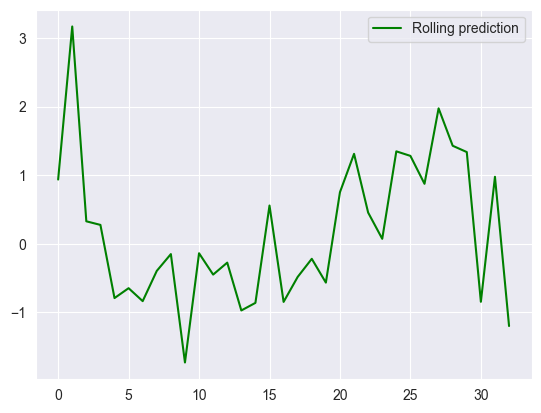

In [15]:
# Initialize an empty list to store the rolling predictions
ypredr=[]
st=X_test_t[0].reshape(1, 1, 24)
tmp=st
ptmp=st
# Predict the first value and append it to the list
val=model.predict(st)
ypredr.append(val.tolist()[0])
# Perform rolling prediction for the remaining samples in the test set
for i in range(1, X_test_t.shape[0]):
    # Shift the previous prediction and create a new input sequence
    tmp=np.append(val, tmp[0,0, 0:-1])
    tmp=tmp.reshape(1, 1, 24)
    # Stack the new input sequence for tracking
    ptmp=np.vstack((ptmp,tmp))
    # Predict the next value and append it to the list
    val=model.predict(tmp)
    ypredr.append(val.tolist()[0])
# Plot the rolling predictions
plt.plot(ypredr,color="green", label = "Rolling prediction")
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


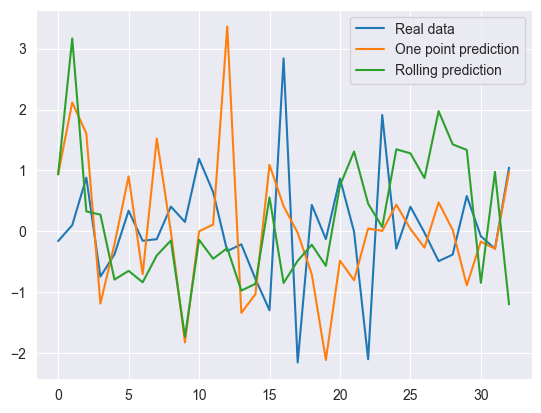

In [16]:
y_pred = model.predict(X_test_t)
plt.plot(d, label = "Real data")
plt.plot(y_pred, label = "One point prediction")
plt.plot(ypredr, label = "Rolling prediction")
plt.legend()
plt.show()